# Week 4 - Word Embeddings

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/czd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, using a function from a couple weeks ago `loadTextDirectory`:

In [4]:
kennedyDF = lucem_illud.loadTextDirectory('../data/grimmerPressReleases/Kennedy/')
kennedyDF[:5]

,text
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...


This gets us one Senator's data, but with no metadata, we can add a category column with a simple command:

In [5]:
kennedyDF['category'] = 'Kennedy'
kennedyDF[:5]

,text,category
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


We also will be wanting to load all the senators so we will need to loop over all the directories

In [6]:
dataDir = '../data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorDir in (file for file in os.scandir(dataDir) if not file.name.startswith('.') and file.is_dir()):
    senDF = lucem_illud.loadTextDirectory(senatorDir.path)
    senDF['category'] = senatorDir.name
    senReleasesDF = senReleasesDF.append(senDF, ignore_index = False)

senReleasesDF[:5]

,text,category
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


We also want to remove stop words and stem. Tokenizing requires two steps. Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone. As such, tokenizing is slightly more involved, but we can still use `lucem_illud`.

In [7]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

senReleasesDF[:5]

,text,category,tokenized_sents,normalized_sents
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, wash..."
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, wash..."
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."


# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data, we give all the sentences to the trainer. We just need to add the words as a list of sentences:

In [7]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

Inside the word2vec object, the words each have a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [8]:
print("A {} dimesional vector:".format(senReleasesW2V['president'].shape[0]))
senReleasesW2V['president']

A 100 dimesional vector:


array([ 2.30339050e+00, -1.76357043e+00,  2.55048513e+00,  1.99355614e+00,
       -1.35247302e+00,  9.70095277e-01, -1.73895434e-01, -7.47145787e-02,
        1.02505839e+00, -2.21239591e+00, -1.85035735e-01, -1.66594759e-01,
        2.43685341e+00,  1.83294261e+00, -5.38275599e-01,  1.53108999e-01,
       -2.36452413e+00, -6.31232440e-01, -9.17102695e-01,  2.70953745e-01,
        6.03676438e-01,  4.36816812e-01, -2.87314272e+00, -1.41489112e+00,
       -1.42786431e+00, -7.24204481e-01,  1.60836220e+00, -1.02538121e+00,
       -6.93277180e-01, -7.69155622e-01,  1.05041039e+00, -2.85863423e+00,
       -1.43470085e+00, -7.12633789e-01,  3.49982947e-01,  8.08036253e-02,
        1.93273529e-01,  3.72858071e+00, -1.64750361e+00,  1.76591003e+00,
        1.87317097e+00,  5.24482787e-01,  1.17867041e+00,  8.79471302e-01,
       -1.45901597e+00,  1.81700265e+00,  9.12630498e-01,  1.78307188e+00,
       -2.12498045e+00, -1.19465148e+00,  1.73755622e+00, -1.94342184e+00,
       -6.28403485e-01,  

If you want the full matrix, `syn0` stores all the vectors:

In [9]:
senReleasesW2V.wv.syn0

array([[-3.62124555e-02,  5.37954867e-01, -1.13834751e+00, ...,
        -4.50650871e-01,  1.20843887e+00, -1.37342036e+00],
       [ 2.45421663e-01,  2.10670877e+00,  9.79076743e-01, ...,
         6.49043083e-01,  1.04291117e+00, -4.61428203e-02],
       [ 2.70196700e+00, -1.50793195e+00, -4.54737782e-01, ...,
         2.69710533e-02,  1.15770131e-01, -1.25612617e+00],
       ...,
       [-2.46335510e-02,  4.66836914e-02,  1.02517210e-01, ...,
         6.34911135e-02, -1.09182678e-01,  7.26778433e-02],
       [ 2.16303170e-02,  2.38120439e-03,  8.79529491e-02, ...,
         3.95261198e-02,  2.47571282e-02,  4.80741635e-03],
       [ 7.62739927e-02,  4.76447269e-02,  1.01364315e-01, ...,
         8.90460163e-02, -7.44280219e-02,  9.72193554e-02]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words

In [10]:
senReleasesW2V.wv.index2word[10]

'american'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [11]:
senReleasesW2V.most_similar('president')

[('administration', 0.8000612258911133),
 ('presidents', 0.7179593443870544),
 ('administrations', 0.6878732442855835),
 ('cheney', 0.5809541344642639),
 ('george', 0.5648810267448425),
 ('responds', 0.5525197982788086),
 ('veto', 0.49843159317970276),
 ('republican', 0.4956115186214447),
 ('invaded', 0.4947235584259033),
 ('gop', 0.4871729016304016)]

In [12]:
senReleasesW2V.most_similar('war')

[('wars', 0.6791698932647705),
 ('descending', 0.6670769453048706),
 ('afghanistan', 0.6511711478233337),
 ('chaos', 0.6391745209693909),
 ('disobedience', 0.6274658441543579),
 ('quagmire', 0.6253349781036377),
 ('sliding', 0.61304771900177),
 ('foment', 0.5919989943504333),
 ('militarily', 0.5885466933250427),
 ('sending', 0.5839246511459351)]

Or we can get this directly (calculated slightly differently):

In [1]:
def cos_difference(embedding,word1,word2):
    return sklearn.metrics.pairwise.cosine_similarity(embedding[word1].reshape(1,-1),embedding[word2].reshape(1,-1))

In [14]:
cos_difference(senReleasesW2V, 'war', 'unwinnable')

array([[0.4045713]], dtype=float32)

We can also find which word least matches the others within a word set (cosine similarity):

In [15]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [16]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('bush', 0.6530749797821045),
 ('bushs', 0.643796443939209),
 ('veto', 0.6324011087417603),
 ('signing', 0.6274088621139526),
 ('signature', 0.62520432472229),
 ('proposing', 0.6160760521888733),
 ('signed', 0.6159865856170654),
 ('sign', 0.6102637648582458),
 ('vetoed', 0.6074589490890503),
 ('reverse', 0.5957595109939575)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset and period, **Clinton** was to **Democrat** as **Bush** was to **Republican**. Whoah!

 But how do we argue that these are stable distances or associations?

## Establishing Credible or Confidence Intervals

### Boostrapping approach

We propose well-established bootstrapping and subsampling methods to nonparametrically demonstrate the stability and significance of word associations within our embedding model. These allow us to establish conservative confidence intervals to both (a) distances between words in a model and (b) projections of words onto an induced dimension (e.g., man-woman). If we assume that the texts (e.g., newspapers, books) underlying our word embedding model are observations drawn from an independent and identically distributed (i.i.d.) population of cultural observations, then bootstrapping allows us to estimate the variance of word distances and projections by measuring those properties through sampling the empirical distribution of texts with replacement (Efron and Tibshirani 1994; Efron 2003). Operationally, if we wanted to bootstrap a 90% confidence interval of a word-word distance or word-dimension projection, we would sample a corpus the same size as the original corpus, but with replacement, 20 times, estimate word embedding models on each sample. Then we take the 2nd order (2nd smallest) statistic $s_{(2)}$--either distance or projection--as our confidence interval’s lower bound, and 19th order statistic $s_{(19)}$ as its upper bound. The distance between $s_{(2)}$ and $s_{(19)}$ across 20 bootstrap samples span the 5th to the 95th percentiles of the statistic’s variance, bounding the 90th confidence interval. A 95% confidence interval would span $s_{(2)}$ and $s_{(39)}$ in word embedding distances or projections estimated on 40 bootstrap samples of a corpus, tracing the 2.5th to 97.5th percentiles. 

In [17]:
estimatesB=[]
for x in range(20):
    senReleasesW2VB = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sample(frac=1.0, replace=True).sum())
    try:
        estimatesB.append(cos_difference(senReleasesW2VB, 'war', 'unwinnable')[0,0])
    except KeyError:
        #Missing one of the words from the vocab
        pass
                                                      
estimatesB.sort()         
estimatesB

[0.3077817,
 0.31900012,
 0.38668165,
 0.4111389,
 0.41611618,
 0.4226749,
 0.43276682,
 0.43497938,
 0.4604326,
 0.49920022,
 0.5308198,
 0.5403556,
 0.55404073,
 0.5602777,
 0.5710476,
 0.59749997,
 0.60074365,
 0.635484]

In [18]:
print("The 90% confidence interval for the cosine distance between war and unwinnable is:\n",estimatesB[1], estimatesB[-2])

The 90% confidence interval for the cosine distance between war and unwinnable is:
 0.31900012 0.60074365


### Subsampling approach

If the corpus is large, then we may take a subsampling approach, which randomly partitions the corpus into non-overlapping samples, then estimates the word-embedding models on these subsets and calculates confidence intervals as a function of the empirical distribution of distance or projection statistics and number of texts in the subsample (Politis and Romano 1997). Subsampling requires the same i.i.d. assumption as the bootrap (Politis and Romano 1992; Politis and Romano 1994). For 90% confidence intervals, we randomly partition the corpus into 20 subcorpora, then calculate $B^k=\sqrt{\tau_k}\left(s^k-\bar{s}\right)$ for each $k$th sample, where $k$ is the number of texts and $s^k$ is the embedding distance or projection for the $k$th sample, and $\bar{s}$ is the average statistic for all samples. The 90% confidence interval spans the 5th to 95th percentile variances, inscribed by $\bar{s}-\frac{B_{(19)}^k}{\sqrt{\tau}}$ and $\bar{s}-\frac{B_{(2)}^k}{\sqrt{\tau}}$, where $\tau$ the number of texts in the total corpus and $s$ is the average statistic across all subsamples. As with bootrapping, a 95% confidence interval would require 40 subsamples; a 99% confidence would require 200 (.5th to 99.5th percentiles).

In [41]:
senReleasesDF[sample_indices == i]

NameError: name 'sample_indices' is not defined

In [42]:
n_samples = 10
sample_indices = np.random.randint(0,n_samples,(len(senReleasesDF),))

s_k =np.array([])
tau_k=np.array([])

for i in range(n_samples):
    sample_w2v = gensim.models.word2vec.Word2Vec(senReleasesDF[sample_indices == i]['normalized_sents'].sum())
    try:
        #Need to use words present in most samples
        s_k = np.append(s_k, cos_difference(sample_w2v, 'war', 'responsibility')[0,0])
    except KeyError:
        pass
    else:
        tau_k = np.append(tau_k, len(senReleasesDF[sample_indices == i]))

print(s_k)
print(tau_k)

tau = tau_k.sum()
s = s_k.mean()
B_k = np.sqrt(tau_k) * s_k-s_k.mean()

[0.96648359 0.91908026 0.99089253 0.9406274  0.96226263 0.99186927
 0.96178007 0.98843431 0.99858981 0.99157006]
[381. 408. 390. 382. 385. 415. 405. 367. 384. 387.]


In [43]:
print("The 90% confidence interval for the cosine distance between war and responsibility is:\n",s-B_k[-2]/np.sqrt(tau), s-B_k[1]/np.sqrt(tau))

The 90% confidence interval for the cosine distance between war and responsibility is:
 0.6735192597867107 0.6895842527772978


We can also save the vectors for later use:

In [44]:
senReleasesW2V.save("senpressreleasesWORD2Vec.mm")
#Load with senReleasesW2V = gensim.models.word2vec.Word2Vec.load('senpressreleasesWORD2Vec.mm')

## Visualize

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [45]:
numWords = 150
targetWords = senReleasesW2V.wv.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [46]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.03621246,  0.53795487, -1.1383475 , ..., -0.45065087,
         1.2084389 , -1.3734204 ],
       [ 0.24542166,  2.1067088 ,  0.97907674, ...,  0.6490431 ,
         1.0429112 , -0.04614282],
       [ 2.701967  , -1.507932  , -0.45473778, ...,  0.02697105,
         0.11577013, -1.2561262 ],
       ...,
       [-1.3226792 , -0.45282215, -0.7804884 , ...,  1.3065096 ,
        -1.5463005 , -2.4090538 ],
       [ 0.21499479,  0.20117383,  0.14299053, ..., -0.2432906 ,
         1.0188694 , -0.09571878],
       [-0.29040447,  2.0648084 , -0.50942326, ...,  0.99708337,
         1.1717469 ,  0.9144734 ]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [47]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

We now can plot the points

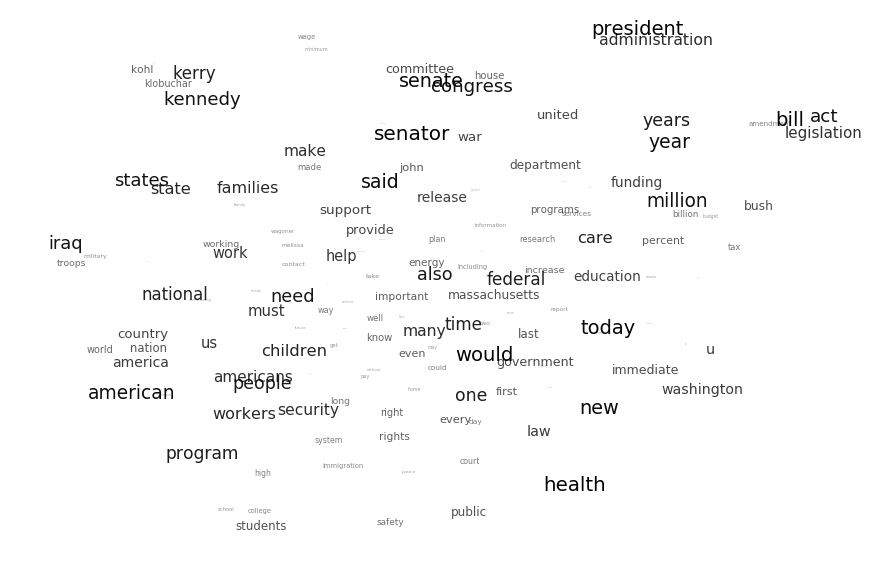

In [48]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``iraq`` next to ``time`` and ``bill`` near ``help``. <img src='../data/examplewordcloud.svg'>

What if a new senator come along with whose names starts with K? Could we analyse their releases too without rerunning the entire embedding? Lets try with Cardin in `../data/grimmerPressReleases_extra/Cardin`. First we need to load and proccess the releases:

In [49]:
cardinDF = lucem_illud.loadTextDirectory('../data/grimmerPressReleases_extra/Cardin')
cardinDF['category'] = 'Cardin'

cardinDF['tokenized_sents'] = cardinDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
cardinDF['normalized_sents'] = cardinDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

cardinDF[:10]

,text,category,tokenized_sents,normalized_sents
01Aug2007Cardin156.txt,...,Cardin,"[[CARDIN, MIKULSKI, PRAISES, PASSAGE, OF, STRO...","[[cardin, mikulski, praises, passage, strong, ..."
01Feb2007Cardin297.txt,...,Cardin,"[[CARDIN, VOTES, TO, INCREASE, MINIMUM, WAGE, ...","[[cardin, votes, increase, minimum, wage, pay,..."
01Feb2007Cardin298.txt,...,Cardin,"[[S, 453, SEN, CARDIN, CO, SPONSORS, BILL, TO,...","[[sen, cardin, co, sponsors, bill, protect, vo..."
01Feb2007Cardin299.txt,...,Cardin,"[[S, 450, CARDIN, INTRODUCES, BILL, TO, ELIMIN...","[[cardin, introduces, bill, eliminate, arbitra..."
01Jun2007Cardin199.txt,...,Cardin,"[[CARDIN, MIKULSKI, ANNOUNCE, 7, 3, MILLION, F...","[[cardin, mikulski, announce, million, hagerst..."
01Jun2007Cardin200.txt,...,Cardin,"[[CARDIN, MIKULSKI, ANNOUNCE, 4, 6, MILLION, F...","[[cardin, mikulski, announce, million, salisbu..."
01Mar2007Cardin279.txt,...,Cardin,"[[SEN, CARDIN, FIGHTS, TO, IMPROVE, SECURITY, ...","[[sen, cardin, fights, improve, security, amer..."
01Mar2007Cardin280.txt,...,Cardin,"[[CARDIN, MIKULSKI, ANNOUNCE, 35, 000, FOR, WE...","[[cardin, mikulski, announce, western, marylan..."
01May2007Cardin228.txt,...,Cardin,"[[STATEMENT, BY, U, S, SENATOR, BENJAMIN, L, C...","[[statement, u, senator, benjamin, l, cardin, ..."
01May2007Cardin229.txt,...,Cardin,"[[CARDIN, TELLS, THE, AG, COMMITTEE, THAT, THE...","[[cardin, tells, ag, committee, farm, bill, co..."


We can now merge Cardin's releases with the rest. This can update all the weights in *w2v* model, so be careful.

In [50]:
#This is using a newer API so we have to tell it a little bit more for it to work right
senReleasesW2V.build_vocab(cardinDF['normalized_sents'].sum(), update=True)
senReleasesW2V.train(cardinDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=senReleasesW2V.iter)
senReleasesW2V.save("senpressreleasesWORD2Vec_new.mm")

As the model is updated by this, we need to load our old copy to do a comparison.

In [51]:
senReleasesW2V_old = gensim.models.word2vec.Word2Vec.load('senpressreleasesWORD2Vec.mm')

In [52]:
print("A {} dimesional vector:".format(senReleasesW2V['president'].shape[0]))
senReleasesW2V['president'][:10]

A 100 dimesional vector:


array([ 2.3992162 , -1.921365  ,  3.227936  ,  1.8831315 , -1.0820767 ,
        0.97057235, -0.12439359,  0.02225613,  1.0300448 , -2.4007735 ],
      dtype=float32)

In [53]:
print("A {} dimesional vector:".format(senReleasesW2V_old['president'].shape[0]))
senReleasesW2V_old['president'][:10]

A 100 dimesional vector:


array([ 2.3033905 , -1.7635704 ,  2.5504851 ,  1.9935561 , -1.352473  ,
        0.9700953 , -0.17389543, -0.07471458,  1.0250584 , -2.212396  ],
      dtype=float32)

In [54]:
(senReleasesW2V_old['president'] - senReleasesW2V['president'])[:10]

array([-9.5825672e-02,  1.5779459e-01, -6.7745090e-01,  1.1042464e-01,
       -2.7039635e-01, -4.7707558e-04, -4.9501844e-02, -9.6970707e-02,
       -4.9864054e-03,  1.8837762e-01], dtype=float32)

As you can see the vector for 'president' has changed a little bit and the word cloud should also be a bit different too

In [55]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

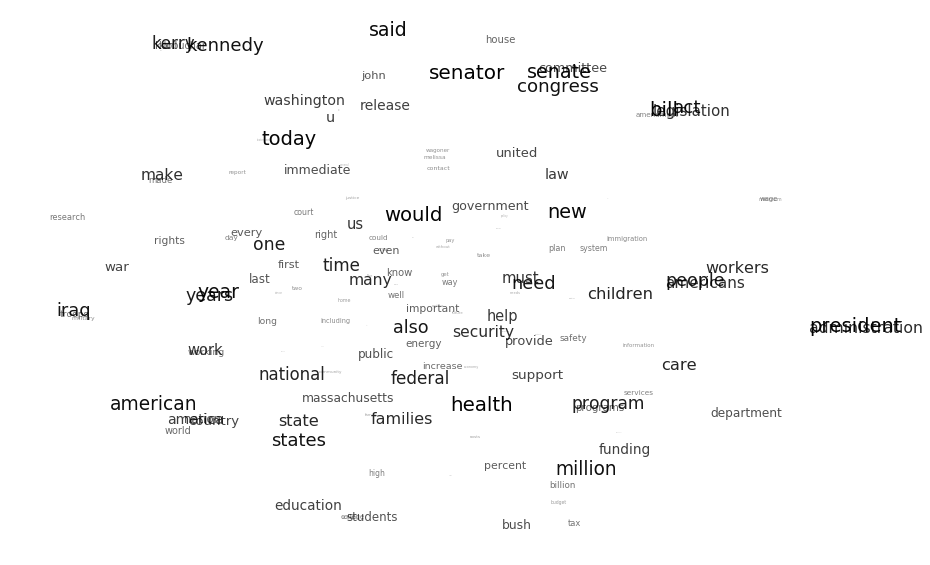

In [56]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

Another thing to consider in training is how we know that our parameters for the model are correct. We can do this by looking at the training loss of the model. Let's tart by training a new model, but this time we will expose most of the options and train it one epoch at a time. Look [here](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) for more detail: 

In [57]:
senReleasesW2V_loss = gensim.models.word2vec.Word2Vec(size = 100, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
senReleasesW2V_loss.build_vocab(senReleasesDF['normalized_sents'].sum())
senReleasesW2V_loss.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
#Using a list so we can capture every epoch
losses = [senReleasesW2V_loss.running_training_loss]
losses[0]

1984792.0

Now we have the training loss and can optimize training to minimize it.

In [58]:
for i in range(19):
    senReleasesW2V_loss.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1,
                             )
    losses.append(senReleasesW2V_loss.running_training_loss)
    print("Done epoch {}".format(i + 2), end = '\r')

Lets plot the loss vs epoch

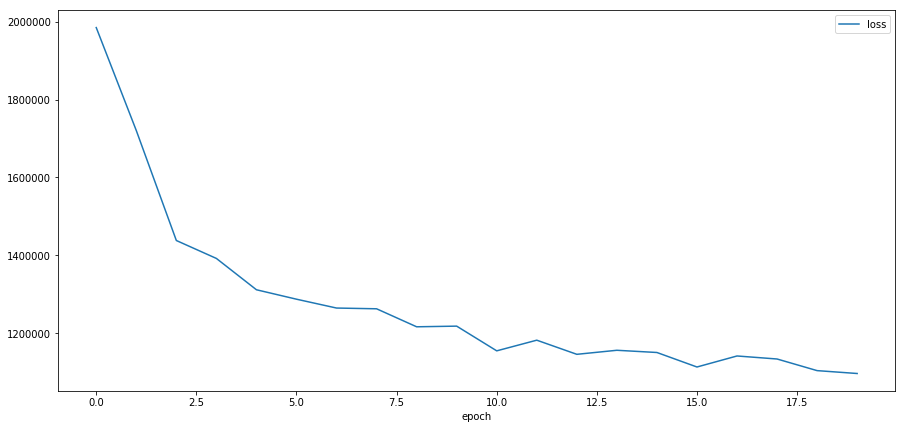

In [59]:
lossesDF = pandas.DataFrame({'loss' : losses, 'epoch' : range(len(losses))})
lossesDF.plot(y = 'loss', x = 'epoch', logy=False, figsize=(15, 7))
plt.show()

You should see that the loss is almost monotonic, but that the rate decreases as epoch increases. Since we are testing on our training data monotonicity is a common result and we must try to avoid over fitting. A simple way to do this is to stop training when there is significant change in the rate of decrease. In this run, that looks to be approximately 8 or 9. If we were to do another analysis, we might use an `iter=9` instead of the default 5.

Even more culturally interesting is how many dimensions are required to achieve an optimal embedding. The use of words in complex ways and contradictory contexts will require more dimensions to represent them with integrity. For example, if one word, $w_a$, is "nearby" $w_b$, but $w_b$ is not near the other words beside $w_a$, then a new dimension will be required for the two words to be uniquely together. 

In [60]:
losses_dims=[]

for d in [50,100,150,200,250,300,350,400,450,500, 550, 600, 650, 700, 750]:
    senReleasesW2V_loss_dims = gensim.models.word2vec.Word2Vec(size = d, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
    senReleasesW2V_loss_dims.build_vocab(senReleasesDF['normalized_sents'].sum())
    senReleasesW2V_loss_dims.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=7, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
    senReleasesW2V_loss_dims.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
    
    losses_dims.append(senReleasesW2V_loss_dims.running_training_loss/(10+d*10))

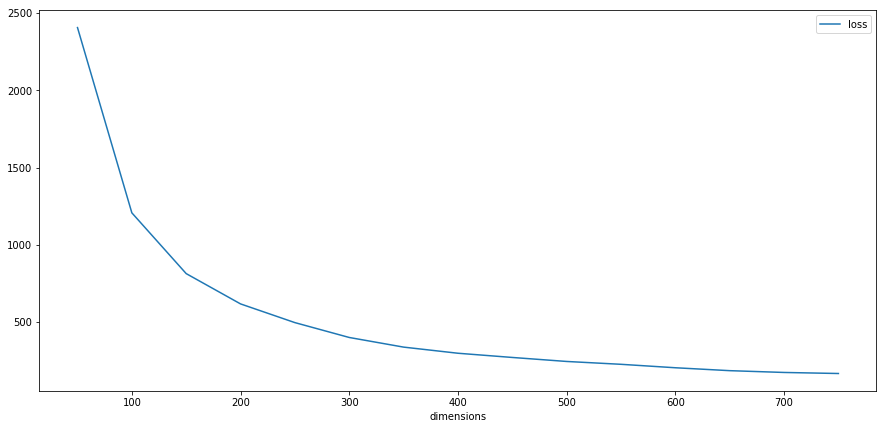

In [61]:
losses_dimsDF = pandas.DataFrame({'loss' : losses_dims, 'dimensions' : [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750]})
losses_dimsDF.plot(y = 'loss', x = 'dimensions', logy=False, figsize=(15, 7))
plt.show()

This is a work in progress for Gensim, but its clear that most of the word distance variation is captured by 300 dimensions.

# Chinese examples

In [21]:
model=gensim.models.Word2Vec.load('../data/1992embeddings_hs_new3.sg')

FileNotFoundError: [Errno 2] No such file or directory: '../data/1992embeddings_hs_new3.sg'

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [ ]:
mm = model.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

In [ ]:
mm = model.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

Second, location analogy: **country -> capital**

In [ ]:
mm = model.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

## similar words

In [ ]:
word = u'社会主义'  #socialism
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

In [ ]:
word = u'玉米'  # corn
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that build a word2vec model with your corpus. Interrogate word relationships in the resulting space, including estimating 90% confidence intervals for specific word cosine distances of interest. Plot a subset of your words. What do these word relationships reveal about the *social* and *cultural game* underlying your corpus? What was surprising--what violated your prior understanding of the corpus? What was expected--what confirmed your knowledge about this domain?

## Introduction

In this homework, I aim to analyze Trump's tweets during his first 100 days as the president to explore the semantic relationships between words and therefore understand the implicit story and discursive culture underlying Trump's tweets. 

Using the same corpora, some articles provide interesting to understand Trump's discourse. However, most of them focus on the description and categorization of Trump's tweets, rather than analyzing how certain words embed in his local linguistic contexts and what semantic meanings they have.

Therefore, my homework intend to answer the questions that 1) how certain words and tweets embed in Trump's twitter texts and what semanic relationships they have? 2) what is the discursive culture underlying Trump's discourse and what political implication it may have? I will mainly examine Trump's attitudes, which are (explicitly or implicitly) expressed in his discourse on twitter, toward international relations, homeland security and domestic policies.

My work contains three parts: 1) build a `Word2Vec` model to interrogate how words embed in the space, 2) build a `Doc2Vec` model to explore how different tweets related to each other within the space and 3) identify three dimensions (action, judgement and sentiment) to see what are certain words's projections on these dimensions. Words represent countries, politicians and policies (social issues) will be projected.


### Part 1

### Getting the Corpora: Trump 100 Days Tweets

In this homework, I will analyze the corpora of Trump's tweets for his first 100 days as the president. The data is obtained by `dkloster`'s sharing on GitHub in the `cyberdh` repository.

In [19]:
trumpDF = pandas.read_csv("../data/trump100days.csv")

trumpDF[:5]

,text
0,RT @jmichaelkell: To sum it up:\r\r1. Trump - ...
1,RT @DrDavidDuke: Did John McCain wiretap Presi...
2,RT @PrisonPlanet: The Revolutionary Communist ...
3,"""Team Trump shares tips on keeping their boss ..."
4,RT @larryelder: Rep. @MaxineWaters says Trump'...


Remove stop words and stem.

In [20]:
#Apply our functions, notice each row is a list of lists now
trumpDF['tokenized_sents'] = trumpDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
trumpDF['normalized_sents'] = trumpDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

trumpDF[:5]

,text,tokenized_sents,normalized_sents
0,RT @jmichaelkell: To sum it up:\r\r1. Trump - ...,"[[RT, @, jmichaelkell, :, To, sum, it, up, :, ...","[[rt, jmichaelkell, sum], [trump, sexual, pred..."
1,RT @DrDavidDuke: Did John McCain wiretap Presi...,"[[RT, @, DrDavidDuke, :, Did, John, McCain, wi...","[[rt, drdavidduke, john, mccain, wiretap, pres..."
2,RT @PrisonPlanet: The Revolutionary Communist ...,"[[RT, @, PrisonPlanet, :, The, Revolutionary, ...","[[rt, prisonplanet, revolutionary, communist, ..."
3,"""Team Trump shares tips on keeping their boss ...","[[``, Team, Trump, shares, tips, on, keeping, ...","[[team, trump, shares, tips, keeping, boss, di..."
4,RT @larryelder: Rep. @MaxineWaters says Trump'...,"[[RT, @, larryelder, :, Rep., @, MaxineWaters,...","[[rt, larryelder, maxinewaters, says, trump, c..."


### Word2Vec 

In order to find out word relationship in this corpora, I will use the gensim implementation of *Word2Vec*.

Firstly, I will add the words as a list of sentences.

In [21]:
trumpW2V = gensim.models.word2vec.Word2Vec(trumpDF['normalized_sents'].sum())

Every words has a vector inside the *word2vew* object.

In [22]:
print("A {} dimesional vector:".format(trumpW2V['america'].shape[0]))
trumpW2V['america']

A 100 dimesional vector:


array([-1.0424532e-01,  9.9987030e-01,  2.5802324e+00,  1.5142590e+00,
       -7.2435921e-01,  2.2272149e-01, -7.1626425e-01,  1.1999382e+00,
       -2.2641006e+00,  7.6984811e-01, -6.4517307e-01, -2.0266411e+00,
       -3.9783433e-01,  9.8810321e-01, -7.3455584e-01,  3.0099097e-01,
       -2.0106840e+00, -7.9770014e-02, -1.5061763e-02, -8.5751766e-01,
        3.7421504e-01, -2.6005304e-01, -1.2477795e+00,  1.2264966e+00,
       -2.0268183e+00,  1.8953391e+00, -1.4763142e+00, -2.0922415e+00,
        1.2982304e+00,  9.7261643e-01,  1.9170164e-01, -2.4552493e+00,
       -2.6270711e+00,  1.8108786e+00, -2.3115332e+00,  1.6732953e+00,
       -1.4174434e+00,  6.6187280e-01,  1.8239464e-01, -1.0555933e+00,
        1.5715067e+00,  2.2052429e+00, -2.1031925e-01, -2.5598626e+00,
       -5.6925225e-01, -4.4121629e-01,  3.2935590e-01,  1.0153818e+00,
       -1.3023855e-01, -1.1380073e-01, -7.7457744e-01, -1.1181277e+00,
       -9.1842681e-01, -1.5379407e-01,  7.1655691e-01, -4.5418385e-01,
      

`syn0` hepls us to see the full matrix of vectors

In [23]:
trumpW2V.wv.syn0

array([[ 4.85069305e-01, -9.15071309e-01, -8.86154294e-01, ...,
         5.94726026e-01,  1.00271022e+00,  8.35690856e-01],
       [-9.84372139e-01,  9.95220616e-02, -1.37282419e+00, ...,
        -1.01928699e+00,  1.14015746e+00,  1.91837525e+00],
       [ 1.04045443e-01, -7.03043520e-01,  1.51339576e-01, ...,
        -2.94563979e-01, -1.15749314e-02, -1.09619367e+00],
       ...,
       [ 2.53376719e-02,  9.56992339e-03,  4.19631191e-02, ...,
         1.54421568e-01, -3.68574671e-02,  1.84629729e-03],
       [ 5.49978539e-02, -3.03992368e-02,  6.42089024e-02, ...,
         7.64260814e-02, -2.23259330e-01,  1.16971105e-01],
       [-9.23457090e-03, -2.04558056e-02,  4.58547566e-03, ...,
         7.76924426e-03, -1.43046398e-02,  5.46249337e-02]], dtype=float32)

Use `index2word` to translate from the matrix to words

In [24]:
trumpW2V.wv.index2word[10]

'russia'

Now we are ready to explore the words relationship using word vectors.

Firstly, let's find similar vectors based on cosine similarity.

In [25]:
trumpW2V.most_similar('america')

[('nation', 0.6551533937454224),
 ('country', 0.6270248889923096),
 ('planet', 0.5579394102096558),
 ('mistake', 0.5338702201843262),
 ('safer', 0.5084792375564575),
 ('communities', 0.507427453994751),
 ('lakes', 0.5022403001785278),
 ('opportunity', 0.5013620257377625),
 ('world', 0.5010677576065063),
 ('greater', 0.5010364651679993)]

As we can see, words with most similar vectors to **america** includes **nation**, **country**, **planet**, **mistake**,**safer**, etc. So in Trump's tweets in that period, the word "America" has three kinds of semantic meanings. The first type is a geographical/political/organizational entity, like "nation" and "country"; the second type is what America represent, like "opportunity" and "mistake"; the third type is what a place America is going to be, like "greater" and "safer".

Let's check what's the most similar vectors to China.

In [27]:
trumpW2V.most_similar('china')

[('currency', 0.755163848400116),
 ('manipulator', 0.7129276990890503),
 ('xi', 0.6809791326522827),
 ('trademarks', 0.6762375831604004),
 ('trade', 0.6661167144775391),
 ('thaad', 0.6517518758773804),
 ('japan', 0.6471372246742249),
 ('company', 0.6168237328529358),
 ('nukes', 0.6087804436683655),
 ('tested', 0.6045700311660767)]

In contrary with America, the most sighnificant semantic meaning of **China** is those most prominent aspects in the US-China relationship - like **currency**, **trademarks** and **trade** . Also, in Trump's discourse, **China** is partly equal to **manipulator** and threat (**nukes**).  

Define a function to obtain cosine difference, which helps us look into the similarity of two words directly.

In [28]:
def cos_difference(embedding,word1,word2):
    return sklearn.metrics.pairwise.cosine_similarity(embedding[word1].reshape(1,-1),embedding[word2].reshape(1,-1))

In [32]:
cos_difference(trumpW2V,'america','china')

array([[0.17807773]], dtype=float32)

The cosine difference of america and china is 0.178.

Next, we can see which word least matches the others within a word set (cosine similarity):

In [37]:
trumpW2V.doesnt_match(['american','chinese', 'america','china','japanese','japan'])

'america'

Among the above word set, the word which least matches to others is 'america'. According to the earlier comparison of america and china, it's likely that America has more abundant meanings compare to other countries.

We can also find out which words best matches the result of a semantic equation when the one side of the equation is "america greater".

In [38]:
trumpW2V.most_similar(positive=['america', 'greater'], negative = ['china'])

[('blind', 0.6270215511322021),
 ('nation', 0.6065894365310669),
 ('whites', 0.574662983417511),
 ('sympathy', 0.5556883811950684),
 ('color', 0.5494083166122437),
 ('obligation', 0.5464898943901062),
 ('splash', 0.5386303663253784),
 ('communities', 0.5369362831115723),
 ('bigot', 0.5354350209236145),
 ('hateful', 0.5353617668151855)]

Here we got the equation that **America + Greater = China + Blind**, which means that in Trump's tweets, greater to America is blind to China.

### Establishing Confidence Intervals

In order to make sure the stability and significance of word assciations we have found above with the word2Vec moedel, I will use subsampling approach to establish conservative confidence intervals.

#### Subsampling Approach

Since our corpora is large, the apprach of subsampling can be a better fit, which shares the same i.i.d. assumption as the bootrap, but randomly partitions the corpus into non-overlapping samples, then estimates the word-embedding models on these subsets.

In [62]:
n_samples = 10
sample_indices = np.random.randint(0,n_samples,(len(trumpDF),))

s_k =np.array([])
tau_k=np.array([])

for i in range(n_samples):
    sample_w2v = gensim.models.word2vec.Word2Vec(trumpDF[sample_indices == i]['normalized_sents'].sum())
    try:
        #Need to use words present in most samples
        s_k = np.append(s_k, cos_difference(sample_w2v, 'america', 'greater')[0,0])
    except KeyError:
        pass
    else:
        tau_k = np.append(tau_k, len(trumpDF[sample_indices == i]))

print(s_k)
print(tau_k)

tau = tau_k.sum()
s = s_k.mean()
B_k = np.sqrt(tau_k) * s_k-s_k.mean()

[0.92247438 0.96897799 0.95189273 0.96300924 0.97017306 0.94888794
 0.95688605 0.91150022 0.94695783 0.97767329]
[24426. 24395. 24544. 24351. 24241. 24484. 24769. 24463. 24489. 24641.]


In [63]:
print("The 90% confidence interval for the cosine distance between america and greater is:\n",s-B_k[-2]/np.sqrt(tau), s-B_k[1]/np.sqrt(tau))

The 90% confidence interval for the cosine distance between america and greater is:
 0.6542594965374393 0.6478836287734225


Save the vectors for later use.

In [64]:
trumpW2V.save("trump100daysWORD2Vec.mm")
#Load with trumpW2V = gensim.models.word2vec.Word2Vec.load('trump100daysWORD2Vec.mm')

### Plotting a Subset

Firstly, we have to select a subset that we want to plot. To this end, we can look at the top words form the set:

In [65]:
numWords = 150
targetWords =trumpW2V.wv.index2word[:numWords]

Extract their vectors and create our own smaller matrix that preserved the distances from the original

In [66]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(trumpW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[ 0.4850693 , -0.9150713 , -0.8861543 , ...,  0.594726  ,
         1.0027102 ,  0.83569086],
       [-0.98437214,  0.09952206, -1.3728242 , ..., -1.019287  ,
         1.1401575 ,  1.9183753 ],
       [ 0.10404544, -0.7030435 ,  0.15133958, ..., -0.29456398,
        -0.01157493, -1.0961937 ],
       ...,
       [ 0.8701848 ,  0.686157  , -0.22951809, ...,  0.50355613,
         0.48618597, -0.1368464 ],
       [ 0.7577667 , -2.0986698 , -1.1630788 , ...,  1.4392586 ,
         1.4705877 ,  2.0851858 ],
       [-0.53139627,  0.6903276 ,  0.64961   , ..., -0.9470297 ,
         0.7284925 ,  0.815538  ]], dtype=float32)

Use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. 

In [67]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

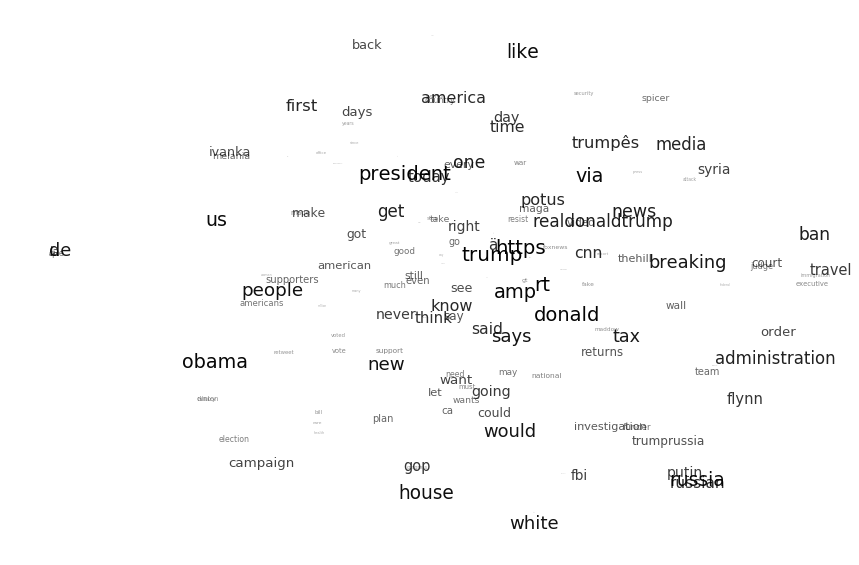

In [174]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = 0.8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

Here we got the wordcloud of the subset. The most frequent includes trump, presidents, people, obama, news, media, america and administartion. 

A few interesting things: 1) trump is in the middle in the wordcloud, 2) america is very far away from russia, 3) "people" in trump's discourse are related to supporters and americans, 4) verbs represent willings are prominent in the wordcloud and very close to each other, like going, could, would, want and need.

Another thing to consider in training is how we know that our parameters for the model are correct. We can do this by looking at the training loss of the model. Let's tart by training a new model, but this time we will expose most of the options and train it one epoch at a time. 

In [69]:
trumpW2V_loss = gensim.models.word2vec.Word2Vec(size = 100, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
trumpW2V_loss.build_vocab(trumpDF['normalized_sents'].sum())
trumpW2V_loss.train(trumpDF['normalized_sents'].sum(), 
                     total_examples=trumpW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
#Using a list so we can capture every epoch
losses = [trumpW2V_loss.running_training_loss]
losses[0]

2050589.25

Now we got the training loss. Then we can optimize training to minimize it.

In [71]:
for i in range(5):
    trumpW2V_loss.train(trumpDF['normalized_sents'].sum(), 
                     total_examples=trumpW2V.corpus_count, 
                     epochs=1,
                             )
    losses.append(trumpW2V_loss.running_training_loss)
    print("Done epoch {}".format(i + 2), end = '\r')

Plot the loss vs epoch

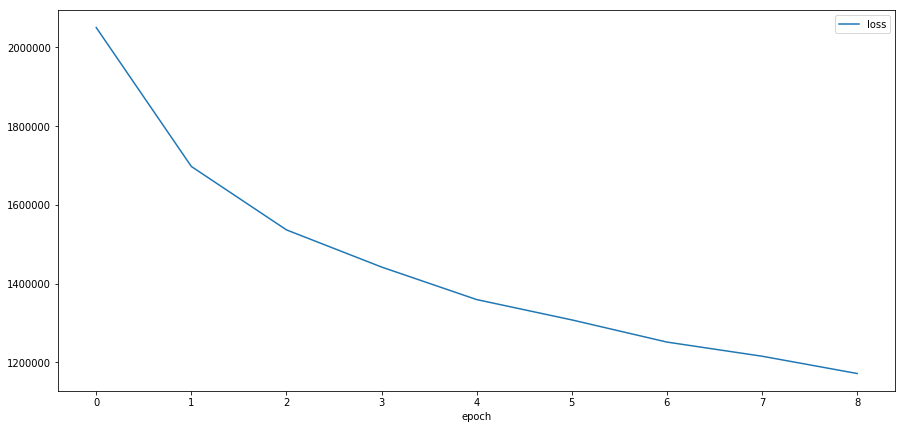

In [72]:
lossesDF = pandas.DataFrame({'loss' : losses, 'epoch' : range(len(losses))})
lossesDF.plot(y = 'loss', x = 'epoch', logy=False, figsize=(15, 7))
plt.show()

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [74]:
apsDF = pandas.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags

In [314]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [77]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: nltk.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))

In [315]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

In [ ]:
for item in apsDF.iterrtuple():
    print(item.Index)
    break

    item.Index

Now we can train a Doc2Vec model:

In [316]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [80]:
apsD2V.docvecs[1952]

array([ 1.7607768 , -1.726842  ,  1.3655665 ,  0.6463644 ,  0.13532308,
       -0.55286705,  0.682568  ,  0.32426852,  0.421908  , -0.3080494 ,
        0.25028768, -0.67192274, -0.71474284, -0.03077906, -1.7261572 ,
        0.59509915, -0.2350166 , -1.0988302 , -0.53397584, -0.14410833,
       -0.99920195,  0.3540797 ,  1.4814746 ,  1.047317  ,  1.0375578 ,
       -0.6190031 ,  2.0920162 ,  0.3292952 ,  1.3814449 , -0.7786298 ,
       -0.8571061 , -0.7393835 , -0.8536269 , -0.6778925 , -0.8482417 ,
       -0.43677115, -0.9361272 , -0.4202842 ,  0.3520281 , -2.1389034 ,
       -0.563125  ,  0.5712731 ,  1.213333  ,  0.7677015 ,  0.33554682,
        1.4017721 , -0.7998668 ,  0.9686334 ,  0.19726498, -1.2156116 ,
        1.2748126 , -0.45797694,  1.2459486 ,  0.38142094,  0.2724068 ,
       -0.685473  , -0.5313144 , -0.11004625, -0.9063298 , -1.0752935 ,
        0.5193495 , -0.5823338 , -0.44093424,  0.4524586 ,  1.072274  ,
        0.11262885, -0.4490415 , -1.5733584 , -0.02185228, -1.08

The words can still be accessed in the same way:

In [81]:
apsD2V['atom']

array([-0.4464416 ,  0.19924589,  1.2260106 ,  0.34595197, -0.31362554,
        0.75132644,  0.26703203, -0.05451898,  0.2563438 ,  0.18178396,
       -0.05469857, -0.65557325, -1.0469142 ,  0.11284927, -0.04551363,
        0.67045987, -0.32842413, -0.0598065 , -0.14665934, -0.04185978,
       -0.67162555, -1.139432  , -0.05513165,  0.3381678 ,  0.3960777 ,
       -0.6022911 ,  1.0328348 ,  0.02234689,  0.34076998, -0.24188983,
       -0.8704423 , -0.37160277, -0.50355107, -0.7137484 ,  0.42789695,
       -0.2468517 , -0.5966891 ,  0.22235852,  0.0891965 , -0.9680104 ,
       -0.369974  ,  0.33476382,  0.8511045 , -0.28807375, -0.6699412 ,
        0.09522177, -0.10501846,  0.07452211,  0.8780625 , -0.08698245,
        1.4946556 , -0.0751031 ,  0.2315625 , -0.4432983 , -0.40732047,
       -0.56010336, -0.21631859, -0.5856304 ,  0.05984148, -0.7411609 ,
       -0.5051303 ,  0.1092569 , -0.07907339, -0.23714103,  0.7423204 ,
        0.6872553 ,  0.49844086, -0.9146933 , -0.28694195,  0.07

We can still use the ``most_similar`` command to perform simple semantic equations:

In [82]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('sputtered', 0.8074467182159424)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [83]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('buckling', 0.9368007183074951)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [84]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.6319893]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [85]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

[('10.1103/PhysRev.100.1646', 0.6584195494651794),
 ('10.1103/PhysRev.112.1429', 0.6507195234298706),
 ('10.1103/PhysRev.112.812', 0.6297498941421509),
 ('10.1103/PhysRev.100.81', 0.6171115636825562),
 ('10.1103/PhysRev.101.1027', 0.6069124937057495)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:
<img src='../data/PhysRev.98.875.jpg'>

Now let's go the other way around and find words most similar to this document:

In [86]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

[('gyromagnetic', 0.7740789651870728),
 ('electric', 0.7038791179656982),
 ('ratio', 0.6863957643508911),
 ('gyration', 0.6835465431213379),
 ('storm', 0.6828193068504333)]

We can even look for documents most like a query composed of multiple words:

In [87]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.100.1646', 0.812326192855835),
 ('10.1103/PhysRev.101.1027', 0.8118253946304321),
 ('10.1103/PhysRev.93.199', 0.7462432980537415),
 ('10.1103/PhysRev.81.848', 0.7365623116493225),
 ('10.1103/PhysRev.109.319', 0.7360200881958008)]

Now let's plot some words and documents against one another with a heatmap:

In [317]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

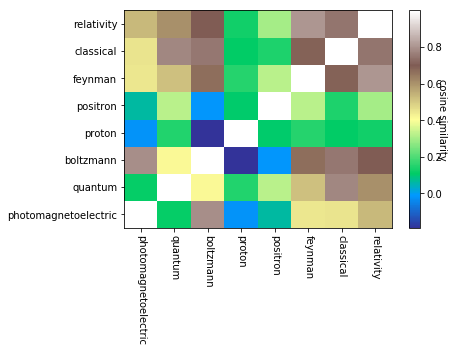

In [89]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [90]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

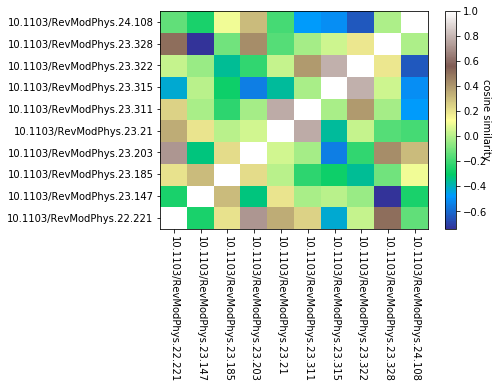

In [91]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [318]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

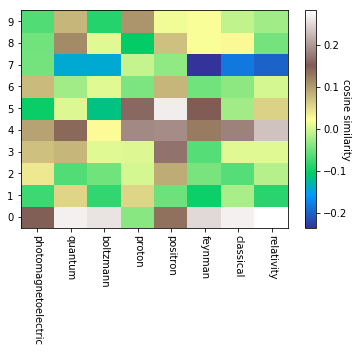

In [319]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [94]:
apsD2V.save('apsW2V')

We can later load it:

In [95]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that build a doc2vec model with your corpus. Interrogate document and word relationships in the resulting space. Construct a heatmap that plots the distances between a subset of your documents against each other, and against a set of informative words. Find distances between *every* document in your corpus and a word or query of interest. What do these doc-doc proximities reveal about your corpus? What do these word-doc proximities highlight? Demonstrate and document one reasonable way to select a defensible subset of query-relevant documents for subsequent analysis.

### Part 2

In this part, I will look at how the different tweets relate to each other within the space.

### Doc2Vec Model

Firstly, I will pick some words as tags. These words are related to  international relations between America and China and America and Mexico.

In [96]:
keywords = ['america','china','military','currency','mexico','security','war','trade','opportunities']

In [129]:
trumpDF['tokenized_words'] = trumpDF['text'].apply(lambda x: nltk.word_tokenize(x))
trumpDF['normalized_words'] = trumpDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))

Insert a column 'id' to identify each documents

In [292]:
trumpDF['id'] = range(len(trumpDF))

In [293]:
trumpDF[:10]

,text,tokenized_sents,normalized_sents,tokenized_words,normalized_words,TaggedAbstracts,id
0,RT @jmichaelkell: To sum it up:\r\r1. Trump - ...,"[[RT, @, jmichaelkell, :, To, sum, it, up, :, ...","[[rt, jmichaelkell, sum], [trump, sexual, pred...","[RT, @, jmichaelkell, :, To, sum, it, up, :, 1...","[rt, jmichaelkell, sum, trump, sexual, predato...","([rt, jmichaelkell, sum, trump, sexual, predat...",0
1,RT @DrDavidDuke: Did John McCain wiretap Presi...,"[[RT, @, DrDavidDuke, :, Did, John, McCain, wi...","[[rt, drdavidduke, john, mccain, wiretap, pres...","[RT, @, DrDavidDuke, :, Did, John, McCain, wir...","[rt, drdavidduke, john, mccain, wiretap, presi...","([rt, drdavidduke, john, mccain, wiretap, pres...",1
2,RT @PrisonPlanet: The Revolutionary Communist ...,"[[RT, @, PrisonPlanet, :, The, Revolutionary, ...","[[rt, prisonplanet, revolutionary, communist, ...","[RT, @, PrisonPlanet, :, The, Revolutionary, C...","[rt, prisonplanet, revolutionary, communist, p...","([rt, prisonplanet, revolutionary, communist, ...",2
3,"""Team Trump shares tips on keeping their boss ...","[[``, Team, Trump, shares, tips, on, keeping, ...","[[team, trump, shares, tips, keeping, boss, di...","[``, Team, Trump, shares, tips, on, keeping, t...","[team, trump, shares, tips, keeping, boss, dis...","([team, trump, shares, tips, keeping, boss, di...",3
4,RT @larryelder: Rep. @MaxineWaters says Trump'...,"[[RT, @, larryelder, :, Rep., @, MaxineWaters,...","[[rt, larryelder, maxinewaters, says, trump, c...","[RT, @, larryelder, :, Rep., @, MaxineWaters, ...","[rt, larryelder, maxinewaters, says, trump, ca...","([rt, larryelder, maxinewaters, says, trump, c...",4
5,@CNNPolitics that's why Trump hired him stupid!,"[[@, CNNPolitics, that, 's, why, Trump, hired,...","[[cnnpolitics, trump, hired, stupid]]","[@, CNNPolitics, that, 's, why, Trump, hired, ...","[cnnpolitics, trump, hired, stupid]","([cnnpolitics, trump, hired, stupid], [])",5
6,RT @NunoyaBusiness: @AltNatParkSer My 73 yr ol...,"[[RT, @, NunoyaBusiness, :, @, AltNatParkSer, ...","[[rt, nunoyabusiness, altnatparkser, yr, old, ...","[RT, @, NunoyaBusiness, :, @, AltNatParkSer, M...","[rt, nunoyabusiness, altnatparkser, yr, old, m...","([rt, nunoyabusiness, altnatparkser, yr, old, ...",6
7,"RT @matthewjdowd: In latest Quinnipiac poll, b...","[[RT, @, matthewjdowd, :, In, latest, Quinnipi...","[[rt, matthewjdowd, latest, quinnipiac, poll, ...","[RT, @, matthewjdowd, :, In, latest, Quinnipia...","[rt, matthewjdowd, latest, quinnipiac, poll, p...","([rt, matthewjdowd, latest, quinnipiac, poll, ...",7
8,RT @LindaSuhler: POTUS Trump's Non-Gaffe on Sw...,"[[RT, @, LindaSuhler, :, POTUS, Trump, 's, Non...","[[rt, lindasuhler, potus, trump, sweden, faken...","[RT, @, LindaSuhler, :, POTUS, Trump, 's, Non-...","[rt, lindasuhler, potus, trump, sweden, fakene...","([rt, lindasuhler, potus, trump, sweden, faken...",8
9,RT @Impeach_D_Trump: Someone needs to tell me ...,"[[RT, @, Impeach_D_Trump, :, Someone, needs, t...","[[rt, someone, needs, tell, gop, amp, presiden...","[RT, @, Impeach_D_Trump, :, Someone, needs, to...","[rt, someone, needs, tell, gop, amp, president...","([rt, someone, needs, tell, gop, amp, presiden...",9


In [294]:
taggedDocs = []

for index, row in trumpDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['id'])
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
trumpDF['TaggedAbstracts'] = taggedDocs

Train a Doc2Vec model

In [295]:
trumpD2V = gensim.models.doc2vec.Doc2Vec(trumpDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

Get vectors for the tags/documents. Documents are actually the centroids (high dimensional average points) of their words.

In [296]:
trumpD2V.docvecs[2] 

array([-0.04674668, -0.03038448,  0.01309655, -0.02041698, -0.00490494,
        0.00444307,  0.02371369,  0.03803457, -0.01565395, -0.02832734,
       -0.00630869,  0.0265789 , -0.03861484,  0.03715973,  0.00103758,
       -0.01292328,  0.00376035, -0.01339729, -0.03353685,  0.02903203,
        0.0107031 , -0.01699237,  0.04813949, -0.00243421, -0.02632138,
       -0.00029505, -0.03704903, -0.02335034, -0.00486396, -0.01331432,
        0.02208341,  0.03699989,  0.01607251, -0.01746576, -0.01086839,
        0.01465771, -0.0026024 ,  0.00462369, -0.06365301,  0.0222181 ,
       -0.00277785,  0.00537033, -0.03168979,  0.01728742,  0.02883661,
       -0.04825066,  0.01059683,  0.00681593, -0.02651467, -0.05322282,
       -0.01116666, -0.01328052,  0.03204814, -0.00695627, -0.00936773,
        0.00930004,  0.02790523, -0.04190864,  0.01798464, -0.03862666,
       -0.005836  ,  0.01883461, -0.01439132, -0.02475112,  0.00778142,
       -0.01436241, -0.03006209,  0.02613181,  0.00957418,  0.04

Get vectors for words

In [297]:
trumpD2V['america']

array([-0.89281386, -0.02887072, -0.71606433, -0.5557714 , -0.14922778,
        0.75054884,  1.6933061 ,  0.48189008,  0.07808445,  0.66657215,
       -0.9208506 , -0.54804486,  0.18176296,  0.33288145, -1.060563  ,
       -0.6828194 ,  0.49309552, -0.23333603,  0.8898742 ,  0.4807446 ,
       -1.1299332 , -0.12954988, -1.6326277 ,  1.560863  , -0.96718156,
        1.5065128 , -0.3888272 , -1.6918472 ,  0.69570154,  1.1623188 ,
        1.8302845 , -1.4945405 , -2.0621266 ,  1.3863742 ,  0.20065613,
        0.9269699 , -0.22538608, -0.33414406, -0.16899909,  0.15612543,
       -0.70244586,  0.20148635, -0.9299406 , -1.924069  , -1.4874067 ,
       -0.34688404,  0.22453368,  0.83502704, -0.752608  ,  0.13615887,
        0.5210704 ,  0.0858512 ,  1.2700713 , -1.2632097 ,  1.1286376 ,
        0.37139097,  0.69184685, -0.62667775, -1.9185708 ,  0.6098375 ,
        0.34776062, -1.1721928 , -0.00944323, -0.45399737, -0.20372596,
       -1.2886498 , -0.16904654,  0.46693164,  0.6542698 ,  2.24

Use the most_similar command to perform simple semantic equations

In [313]:
trumpD2V.most_similar(positive = ['military','trade'], negative = ['war'], topn = 1)

[('commitments', 0.4740705192089081)]

Here, **military** is to **war** as **trade** is to **commitments**.

Compute all of these by hand--explicitly wth vector algebra:

In [299]:
sklearn.metrics.pairwise.cosine_similarity(trumpD2V['military'].reshape(1,-1), trumpD2V['war'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.3886608]], dtype=float32)

### Interrogate Document and Word Relationships

#### Word-Document Relationship

To start, I will calculate the distance between a word and documents in the dataset:

In [300]:
trumpD2V.docvecs.most_similar([ trumpD2V['security'] ], topn=5 )

[('security', 0.8155350089073181),
 (48479, 0.6632248759269714),
 (40903, 0.6172126531600952),
 (177086, 0.6041373610496521),
 (110792, 0.5868842601776123)]

Conversly, Find words most similar to a certain document

In [304]:
trumpD2V.most_similar( [ trumpD2V.docvecs[5] ], topn=5) 

[('lewandowski', 0.6108497381210327),
 ('hired', 0.5523826479911804),
 ('quigley', 0.5239745378494263),
 ('distracts', 0.4976636469364166),
 ('morrell', 0.48937565088272095)]

Look for documents most like a query composed of multiple words

In [302]:
trumpD2V.docvecs.most_similar([ trumpD2V['military']+trumpD2V['security']+trumpD2V['budget']], topn=5 )

[(190784, 0.6670740842819214),
 (134793, 0.6583728790283203),
 (67842, 0.6500887870788574),
 (35952, 0.6481510400772095),
 (112789, 0.6400545835494995)]

### Construct Heatmaps

#### Plot Distances between a Subset of Documents against each other

Plot some words and documents against one another with a heatmap

In [305]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = trumpD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, trumpD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

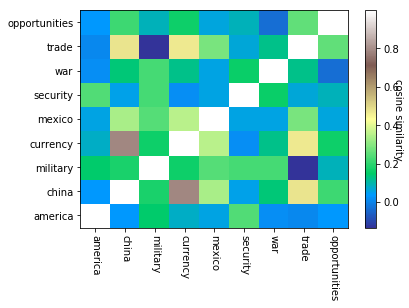

In [306]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

we can see that words with least simialrity is **trade** and **military**. According to the equation above, **trade** is to **commitment** as **military** is to **war**. These two findings reveal that trade and military have different roles and functions to American society, based on Trump's discourse.

Construct a heatmap of similarities between the first ten documents in the corpus

In [307]:
targetDocs = trumpDF['id'][:10] 

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = trumpD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, trumpD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

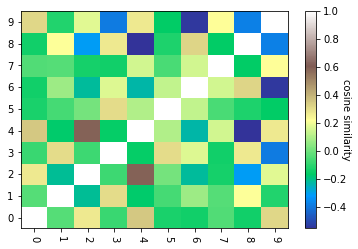

In [308]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Among the first 10 tweets in the corpora, #2 and #4 have highest similarity, while #4 and #8, #6 and #9 have the lowest. 

#### Plot Distances between a Subset of Documents against Informative Words

Construct a heatmap of similarities between the first ten documents and our keywords

In [309]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = trumpD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, trumpD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)


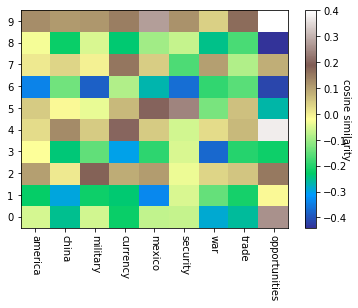

In [310]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

As we can see, tweet #9 has higher similarity with all the keywords, compare to other tweets. Content in document 9 is a retweet of a tweet which was blaming Trump voters. And tweet #6 and #8 have very low similarities with the word opportunities, while tweet #4 has high similarity with it.

Save the model in case we would like to use it again

In [311]:
trumpD2V.save('trumpW2V')
# For later load: apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [104]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [105]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.343139, -0.117117, -0.50773 , ..., -0.995696,  0.921299,
         0.943769],
       [-0.362909, -0.263528,  0.032661, ..., -0.043032, -0.178965,
         0.353556],
       [-0.70167 , -0.344525, -0.320714, ...,  0.009001,  0.11055 ,
         0.751077],
       ...,
       [-2.391626, -1.90143 ,  1.031182, ...,  2.947464,  1.01588 ,
         2.00033 ],
       [-2.432387, -1.161415,  1.060064, ...,  4.402381,  0.500471,
         1.644596],
       [ 0.981931,  0.628094, -0.747547, ...,  1.612927,  1.148063,
         1.063776]], dtype=float32)

In [106]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

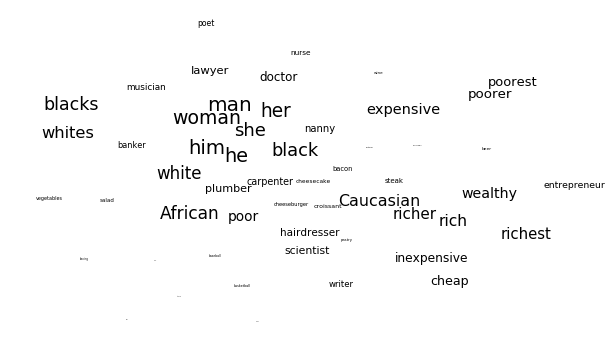

In [107]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  20 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [108]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [109]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [110]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [111]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [112]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [113]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

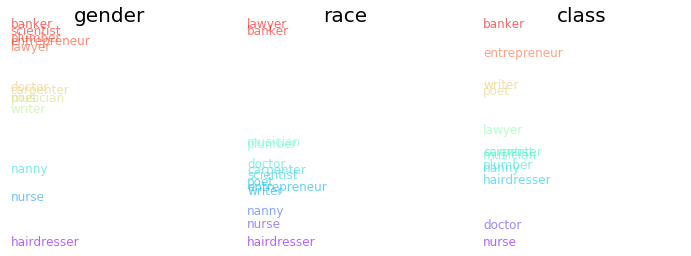

In [114]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

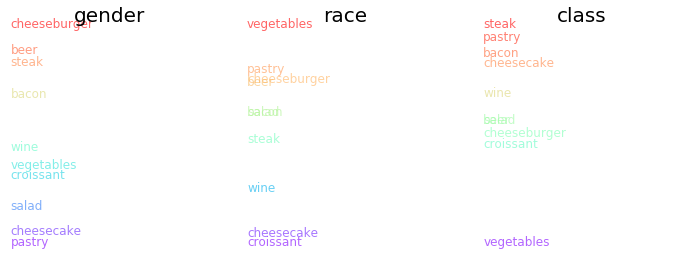

In [115]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

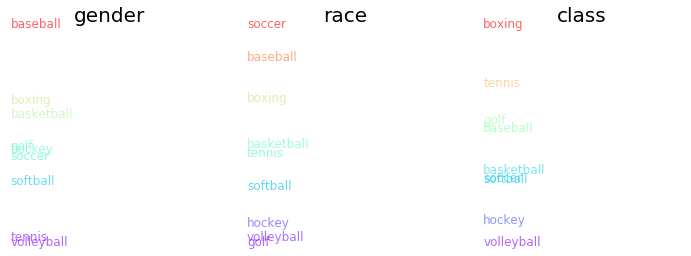

In [116]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that identify semantic dimensions of interest from your data (e.g., gender: man-woman) and project words onto these dimensions. Plot the array of relevant words along each semantic dimension. Which words are most different. Which dimensions are most different? On which dimension are your words most different? Print three short textual examples from the corpus that illustrate the association you have explored.

<span style="color:red">***Stretch***: Project documents from your corpus along a dimension of interest. Sample relevant documents from your corpus with this functionality and explain your rationale? Calculate the cosine of the angle between two dimensions (encoded as vectors) of interest. What does this suggest about the relationship between them within your corpus? 

<span style="color:red">***Stretch***: Create 90% bootstrap confidence intervals around your word projections onto a given dimension. Which words are *significantly* different on your semantic dimension of interest?

### Part 3

In this part, I intend to identify three semantic dimensions in Trump's tweet and make word projection onto these dimensions, in order to explore how words distribute on different semantic dimensions and the political implications behind it.

### Identify Semantic Dimensions

Firstly, I will set up the words that help create dimensions and also the words will be mapped. Then I will visualize with dimension reduction.

The target words I chosse here represents **Actions**, **Judgements** and **Sentiments** in Trump's tweets respectively. The words that will be mapped on dimensions are from the categories of **Country**, **Politician** and **Policy**. I am going to see what semantic meaning on the dimensions of actions, judgments and sentiments that Trump expressed towards different countries, politicians and policies.

In [228]:
trump_model = trumpW2V

In [287]:
#words to create dimensions
trumpTargetWords = ['support', 'help', 'peace','attack', 'fight','war','right','good','legal','truth','wrong','bad','illegal','lie','real','love','great','fake','hate','bad']
#words we will be mapping
trumpTargetWords += ["america","russia","china","korea","japan","mexico","britain","syria","iraq","hillary","clinton","obama","xi","putin","kim","nieto","assad","republican","democrat","media","news","military","education","healthcare","wall","tax","welfare","law","environment","immigration","job","industry"]


wordsSubMatrix = []
for word in trumpTargetWords:
    wordsSubMatrix.append(trump_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.23986943,  1.4190189 , -1.1533484 , ..., -0.2655689 ,
         0.8920332 ,  1.4960346 ],
       [ 0.60527635,  2.2127142 ,  0.5970829 , ..., -0.45611084,
         0.9243823 ,  1.3157449 ],
       [ 0.5621229 ,  1.0191847 ,  0.5340773 , ...,  0.41479018,
         0.1626111 ,  0.3623868 ],
       ...,
       [-0.5893591 ,  1.4997964 ,  0.7646811 , ...,  0.3611351 ,
        -0.99944144, -0.76099896],
       [ 0.91822034, -0.9300432 ,  1.1337794 , ..., -3.2223806 ,
         1.5659968 ,  0.8032216 ],
       [ 0.17966734,  0.16597202,  0.41662005, ..., -0.13415633,
         0.74689615, -0.22612232]], dtype=float32)

In [288]:
pcaWordsTrump = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataTrump = pcaWordsTrump.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsTrump = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataTrump)

Before look into dimensions, let's see how these target words different from each other first.

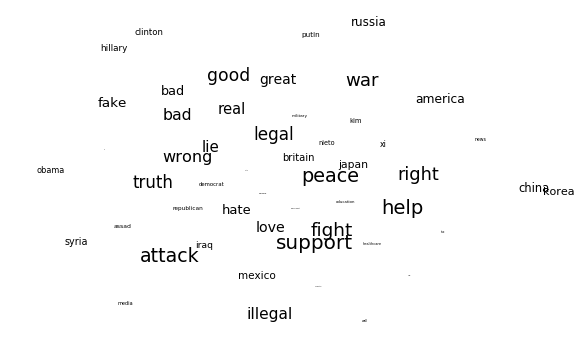

In [289]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsTrump[:, 0], tsneWordsTrump[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(trumpTargetWords):
    ax.annotate(word, (tsneWordsTrump[:, 0][i],tsneWordsTrump[:, 1][i]), size =  20 * (len(trumpTargetWords) - i) / len(trumpTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

A few things we can see from the graph: 

1) while most of the dimensional target words with their counterparts distribute seperately with certain distance on the graph (e.g. legal and illegal, wrong and right, attack and support), the mapping words distribute dispersly around the dimensional words, which means that countries, politicians and policies in Trump's tweet have various semantic meanings based on action, judgement and sentiments. 

2) For words, in the category of country, Syria is the one that have the farthest distance with other countries, which means it is most different in Trump's discourse. While China and Korea near to the action of help, Syria is close to the action of attack. This finding is consistent with Trump's attitude in international relations.

3) For dimensions, the most clear dimension is judgement (legal/illegal, right/wrong distribute as significant counterparts in the graph) while positive-negative comparison of actions and sentiments are more ambiguous, which means that Trump tend to make more clear judgements but ambiguous and maybe contradict actions as well as sentiments towards other countries, politicians and policies in his tweets.

Define some convenient functions for getting dimensions.

In [239]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Calculate three dimensions: **Actions**, **Judgements** and **Sentiments**

In [276]:
Actions = dimension(trump_model,['support', 'help', 'peace'], ['attack', 'fight','war'])
Judgements = dimension(trump_model,['right','good','legal','truth'],['wrong','bad','illegal','lie'])
Sentiments = dimension(trump_model,['real','love','great'],['fake','hate','bad'])

Set up three categories of words: **Country**, **Politician** and **Policy**

In [282]:
Countries = ["america","russia","china","korea","japan","mexico","britain","syria","iraq"]

Names = ["hillary","clinton","obama","xi","putin","kim","nieto","assad","republican","democrat"]

Policies  = ["media","news","military","education","healthcare","wall","tax","welfare","law","environment","immigration","job","industry"]

Define a function to project words in a word list to each of the three dimensions.

In [278]:
def makeDF(model, word_list):
    a = []
    j = []
    s = []
    for word in word_list:
        a.append(sklearn.metrics.pairwise.cosine_similarity(trump_model[word].reshape(1,-1), Actions.reshape(1,-1))[0][0])
        j.append(sklearn.metrics.pairwise.cosine_similarity(trump_model[word].reshape(1,-1), Judgements.reshape(1,-1))[0][0])
        s.append(sklearn.metrics.pairwise.cosine_similarity(trump_model[word].reshape(1,-1), Sentiments.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'Actions': a, 'Judgements': j, 'Sentiments': s}, index = word_list)
    return df

Get the projections.

In [283]:
Countrydf = makeDF(trump_model, Countries) 
Namedf = makeDF(trump_model, Names)
Policydf = makeDF(trump_model, Policies)

### Plot

Define some useful functions for plotting.

In [280]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the words of countries in each of the three dimensions.

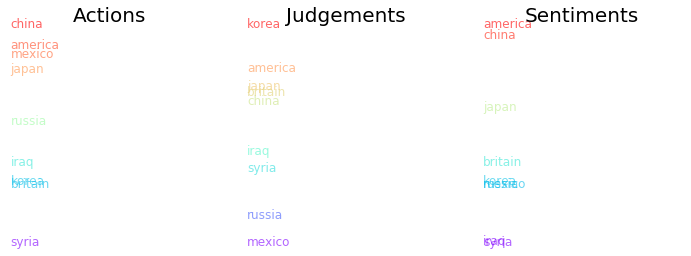

In [281]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Countrydf, 'Actions')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Countrydf, 'Judgements')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Countrydf, 'Sentiments')
plt.show()

In this plot, words on top have positive semantic meanings while bottom represents negative. 

1) Focusing on consistency, Trump's action, judgement and sentiments remain consistently positive towards America and Japan, which means he support America and Japan in action, judge them as right and also have positive sentiments. On the contrary, syria and irap is considered negative in both action and sentiments dimensions, which represents the action of attack & fight and the sentiments of bad & hate. This reveals that Syria and Iraq are considered as major problem in the eyes of president.

2) An interesting finding is that, in the contrary with what we find in the exercise 1 that Blind China equals to Greater America, China's projection on all three dimensions are pretty positive, especially in the actions and sentiments dimension. This contradiction in Trump's discourse reflects the complex relation between the US and China, while holding different political system and ideology, they are still sharing common interests in many areas like trade and industry.

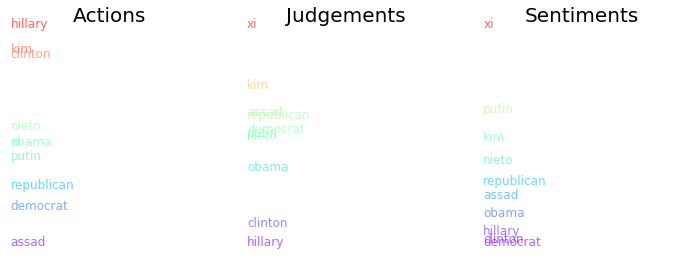

In [285]:
fig = plt.figure(figsize = (12,4)
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Namedf, 'Actions')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Namedf, 'Judgements')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Namedf, 'Sentiments')
plt.show()

For contemporaneous politicians:

1) Trump's tweets show a highly negative judgement and sentiment toward Hillary Clinton, his competitor in the president election. But for actions dimension, actions toward Hillary are shown as highly-positive. This may possibly due to Trump's attempt to repair the relation after the election.

2) Assad, president of Syria, lie on the bottom of the action dimension, which represents the action of "attack", "fight" and "war" toward him in Trump's discourse. This result is consistent with Trump's attitude toward Syria as shown in the last graph.

3) Xi received a highly positive judgement and sentiment in Trump's tweets, which is also consistent with his attitude toward China in the last graph.

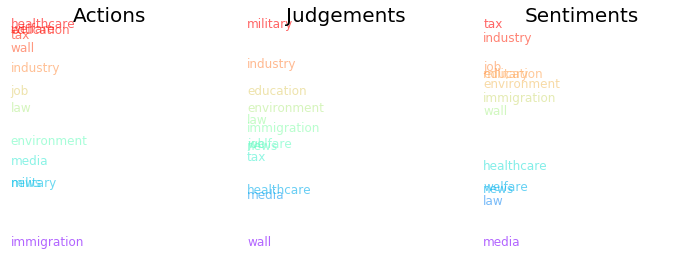

In [286]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Policydf, 'Actions')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Policydf, 'Judgements')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Policydf, 'Sentiments')
plt.show()

For policies (i.e. social issues):
    
1) Health care, which is projected on the top of the dimension of actions, has negative semanic meanings in the dimensions of judgement and sentiments. This contradictory actually make sense because that Trump's bad judgment and sentiment toward health care lead to his positve actions to support and help health care reform. As one of the most prominent issue of Obama's policies, Trump's discourse partly proves his disagreement with his predecessor. The same logic also happens in "wall", which refers to Trump's policy toward Mexico.

2) Industry and education are two issues obtain positive meanings in all the dimensions.

3) Media is basically the only word that has negative sematntic meanings in all the dimensions, which reveals a remarkable characteristic of Trump - the denouncement of media companies as well as fake news.

## Technical Problems I have met

1) My data size is large so it takes extremely long to train a model or conduct bootstrapping (more than half a day), even interrupt them takes a long time. That's why I chose subsampling approach when working on the first exercise.

2) In exercise 2, the data in example is appropriate to construct a heatmap which plots the distance between documents to each other (the column "doi" to extract individual documents). However, my data is texts from twitter, so every document is actually a tweet, without certain column to extract individual documents. With the help of TA, I fixed this by creating a new column with identical id. However, the results from the heatmap is not very interesting and I fail to make meaningful interpretations about the similarity between different tweets.